In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload

import os
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import vectorutils as vu
import palettize
import utils

def pcp(X, title = "", show_legend = False, color = None, label = "f{:d}"):
    df = pd.DataFrame(X, columns = [label.format(i+1) for i in range(X.shape[1])])
    df['X'] = ['X_%s' % i for i in range(X.shape[0])]
    if color is None:
        ax = pd.plotting.parallel_coordinates(df, 'X')
        ax.grid(False)
    else:
        ax = pd.plotting.parallel_coordinates(df, 'X', color = color)
        ax.grid(False)
    if not show_legend:
        plt.gca().legend_.remove()
    plt.title(title)
    
def radviz(data, color = 'red', size = 5.0, label = "f{:d}"):
    m = len(data[0])
    S = [[math.cos(2 * t * math.pi), math.sin(2 * t * math.pi)] \
         for t in [0.0, 0.30, 0.33, 0.35, 0.60, 0.99, 0.66]]
    # [0.0, 0.33, 0.35, 0.66, 0.30, 0.90, 0.99]
    # S = [[math.cos(t), math.sin(t)] for t in [2.0 * math.pi * (i/float(m)) for i in range(m)]]
    columns = [label.format(i+1) for i in range(m)]

    fs = [math.fsum(v) for v in data]
    u = [math.fsum([f[j] * c[0] for j,c in enumerate(S)])/fs[i] for i,f in enumerate(data)]
    v = [math.fsum([f[j] * c[1] for j,c in enumerate(S)])/fs[i] for i,f in enumerate(data)]
    coords = list(zip(u, v))

    fig = plt.figure()
    ax = plt.gca(xlim = [-1, 1], ylim = [-1, 1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    ax.add_patch(mpl.patches.Circle((0.0, 0.0), radius = 1.0, \
                    facecolor = 'none', fill = False, linestyle = '--'))
    for xy, name in zip(S, columns):
        ax.add_patch(mpl.patches.Circle(xy, radius = 0.025, facecolor = 'gray'))
        if xy[0] < 0.0 and xy[1] < 0.0:
            ax.text(xy[0] - 0.025, xy[1] - 0.025, name, ha = 'right', va = 'top', size = 'small')
        elif xy[0] < 0.0 and xy[1] >= 0.0: 
            ax.text(xy[0] - 0.025, xy[1] + 0.025, name, ha = 'right', va = 'bottom', size = 'small')
        elif xy[0] >= 0.0 and xy[1] < 0.0:
            ax.text(xy[0] + 0.025, xy[1] - 0.025, name, ha = 'left', va = 'top', size = 'small')
        elif xy[0] >= 0.0 and xy[1] >= 0.0:
            ax.text(xy[0] + 0.025, xy[1] + 0.025, name, ha = 'left', va = 'bottom', size = 'small')
        ax.axis('equal')
        if knee_idx is not None:
            knee_coords = [coords[i] for i in knee_idx]
            knee_color = [color[i] for i in knee_idx]
            knee_size = [size[i] for i in knee_idx]
            other_idx = list(set([i for i in range(len(coords))]) - set(knee_idx))
            other_coords = [coords[i] for i in other_idx]
            other_color = [color[i] for i in other_idx]
            other_size = [size[i] for i in other_idx]
            # plot others first
            [u, v] = list(zip(*other_coords))
            ax.scatter(u, v, marker = 'o', s = other_size, color = other_color, alpha = 0.35)
            # then knee points
            [u, v] = list(zip(*knee_coords))
            ax.scatter(u, v, marker = 'o', s = knee_size, color = knee_color, alpha = 0.8)
        else:
            [u, v] = list(zip(*coords))
            ax.scatter(u, v, marker = 'o', s = size, color = color)        
#     for i in range(0, len(S)-1):
#         ax.plot([S[i][0], S[i + 1][0]], [S[i][1], S[i + 1][1]], color = 'grey')
#     ax.plot([S[len(S) - 1][0], S[0][0]], [S[len(S) - 1][1], S[0][1]], color = 'grey')
    
def get_centroid(points):
    cols = list(zip(*points))
    centroid = []
    for col in cols:
        centroid.append(sum(col)/len(col))
    return centroid
    
def recolor_by_centroid(points, factor = 1.5):
    """
    Color the points according to the distance from the centroid.
    """
    c = get_centroid(points)
    cdist = []
    maxcdist, mincdist = float('-inf'), float('inf')
    for point in points:
        d = math.sqrt(sum([(p - c[i])*(p - c[i]) \
                           for i, p in enumerate(point)]))
        maxcdist = d if d >= maxcdist else maxcdist
        mincdist = d if d <= mincdist else mincdist
        cdist.append(d)
    color = [cm.winter_r(((v - mincdist)/(maxcdist - mincdist)) * factor) for v in cdist]
    return color
 
def rescale_by_knee(mu):
    """
    Change the sizes of the points according to the trade-off values.
    """
    nonzero_mu = [v for v in mu if v > 0.0]
    min_mu = min(nonzero_mu)
    max_mu = max(nonzero_mu)
    mu_ = vu.normalize(mu, min_mu, max_mu)
    mean_mu = math.fsum(mu_)/len(mu_)
    sd_mu = math.sqrt(math.fsum([(m - mean_mu)**2 for m in mu_])/(len(mu_) - 1))
    # sizes = [15.0 for _ in range(len(mu))]
    sizes = [((m + 0.01) * 100.0) for m in mu_]
    return sizes

def recolor_by_knee(size, color):
    """
    Recolor the points according to the trade-off values. This function
    will change the color of the points with higher trade-offs to 
    dark red.
    """
    max_sz = max(size)
    min_sz = min(size)
    mean_sz = math.fsum(size)/len(size)
    sd_sz = math.sqrt(math.fsum([((s - mean_sz) ** 2) for s in size])/(len(size) - 1))
    knee_idx = [i for i,s in enumerate(size) if s > (mean_sz + 3.0 * sd_sz)]
    knee_sizes = [size[i] for i in knee_idx]
    min_knee = min(knee_sizes)
    max_knee = max(knee_sizes)
#     print("max_sz:", max_sz, "min_sz:", min_sz, "mean_sz:", mean_sz, "sd_sz:", sd_sz)
#     print("knee_idx:", knee_idx)
#     print("min_knee:", min_knee, "max_knee:", max_knee)
    for i in range(len(color)):
        if i in knee_idx:
            knee_range = max_knee - min_knee
            knee_range = 0.0 # we are not doing this anymore.
            if knee_range > 0.0:
                color[i] = cm.Reds(((size[i] - min_knee) / knee_range) * 2.5)
            else:
                color[i] = cm.Reds(2.5)
    return (color, knee_idx)

def recolor_by_cv(cv):
    """
    This function will change the color of the points
    according to the total constraint violation value
    of each point.
    """
    color = [cm.cool(v * 1.0) for v in cv]
    return color

def recolor_by_layers(points, layers, seq = ['red', 'green']):
    """
    This function will change the color of the points
    according to the sequence of the layers. The color
    sequence is given in the seq variable.
    """
    colors = [''] * len(points)
    for i,layer in enumerate(layers):
        color = seq[i % len(seq)]
        for idx in layer:
            colors[idx] = color
    return colors

<IPython.core.display.Javascript object>


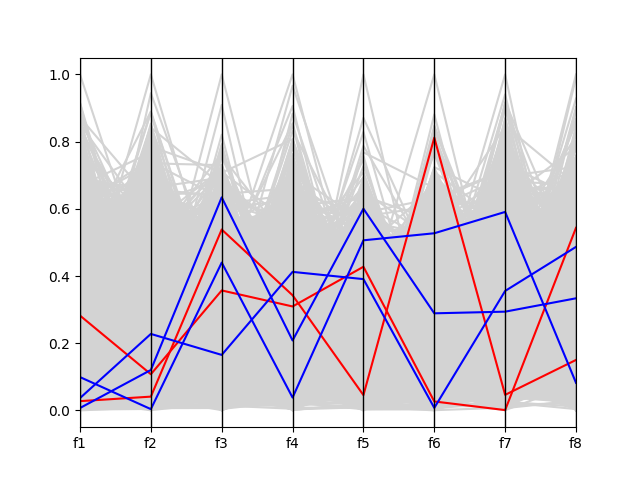

In [2]:
# prefix = "data/knee/knee-3d-norm"
prefix = "data/knee/knee-8d-norm"
# prefix = "data/knee-const/knee-const-8d-norm"
# prefix = "data/isolated/isolated-8d-norm"
# prefix = "data/c2dtlz2/c2dtlz2-8d-norm"
# prefix = "data/line/line-8d-norm"

points = utils.load(prefix + ".out")
mu = mu = [v[0] if len(v) == 1 else v for v in utils.load(prefix + "-mu.out")]
layers = utils.load(prefix + "-layers.out", dtype = 'int')

color = ['lightgrey'] * len(points)
size = rescale_by_knee(mu)
(color, knee_idx) = recolor_by_knee(size, color)
color = ['lightgrey'] * len(points)

all_idx = range(len(points))
non_knee_idx = list(set(all_idx) - set(knee_idx))

knee_pts = [points[i] for i in knee_idx]
non_knee_pts = [points[i] for i in non_knee_idx]
boundary_pts = [points[i] for i in layers[0]]
# print(boundary_pts)

points.extend([knee_pts[0], knee_pts[2]])
points.extend([boundary_pts[0], boundary_pts[1], boundary_pts[10]])

color.extend(['red', 'red'])
# color.extend(['green', 'blue', 'black'])
color.extend(['blue', 'blue', 'blue'])

F = np.array(points)
plt.figure()
pcp(F, "", color = color)

plt.show()

outfile_name = prefix + "-pcp.pdf"
plt.savefig(outfile_name, transparent = False, bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


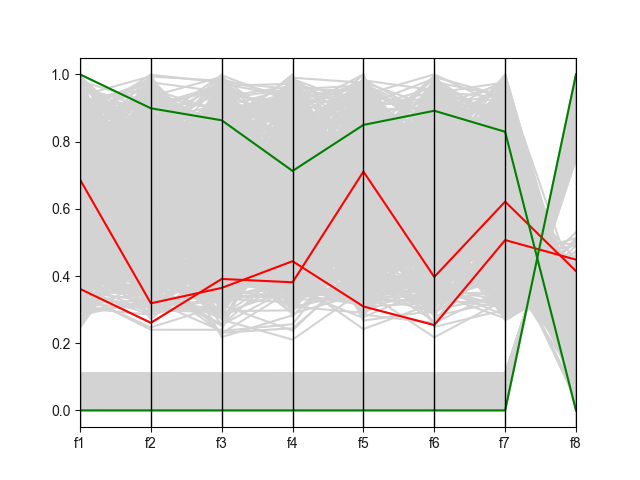

In [3]:
prefix = "data/line/line-8d-norm"

points = utils.load(prefix + ".out")
mu = mu = [v[0] if len(v) == 1 else v for v in utils.load(prefix + "-mu.out")]
layers = utils.load(prefix + "-layers.out", dtype = 'int')

color = ['lightgrey'] * len(points)
size = rescale_by_knee(mu)
(color, knee_idx) = recolor_by_knee(size, color)
color = ['lightgrey'] * len(points)

all_idx = range(len(points))
non_knee_idx = list(set(all_idx) - set(knee_idx))

knee_pts = [points[i] for i in knee_idx]
non_knee_pts = [points[i] for i in non_knee_idx]
boundary_pts = [points[i] for i in layers[0]]

knee_pts.sort()
boundary_pts.sort()

# print(knee_pts)
# print(boundary_pts)

points.extend([knee_pts[-1], knee_pts[-3]])
points.extend([boundary_pts[0], boundary_pts[-1]])

color.extend(['red', 'red'])
color.extend(['green', 'green', 'green'])

F = np.array(points)
plt.figure()
pcp(F, "", color = color)

plt.show()

outfile_name = prefix + "-pcp.pdf"
plt.savefig(outfile_name, transparent = False, bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


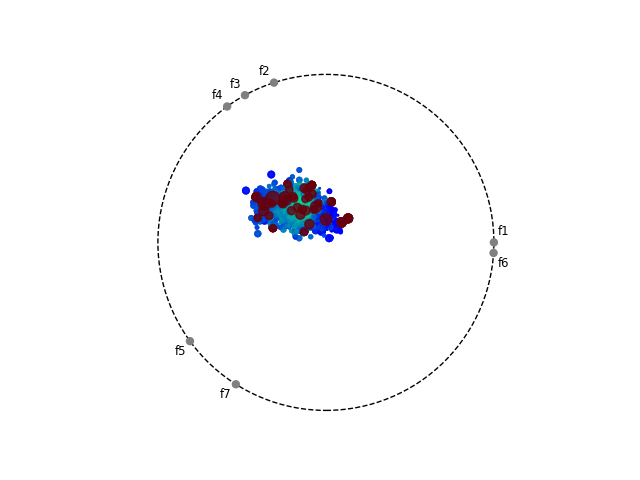

In [6]:
# prefix = "data/knee/knee-8d-norm"
prefix = "data/wil/wil-7d-norm"

docentroid = False

points = utils.load(prefix + ".out")
mu = [v[0] if len(v) == 1 else v for v in utils.load(prefix + "-mu.out")]
# layers = utils.load(prefix + "-layers.out", dtype = 'int')

cvfilepath = prefix.split('.')[0].split('-norm')[0] + "-cv.out"
if not docentroid and os.path.exists(cvfilepath):
    cv = [v[0] if len(v) == 1 else v for v in utils.load(cvfilepath)]
    [low, up] = vu.get_bound(cv)
    cv = vu.normalize(cv, low, up)
    color = recolor_by_cv(cv)
else:
    color = recolor_by_centroid(points, 1.5)

size = rescale_by_knee(mu)
(color, knee_idx) = recolor_by_knee(size, color)

radviz(points, color = color, size = size)
plt.show()

outfile_name = prefix + "-radviz.pdf"
plt.savefig(outfile_name, transparent = False, bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


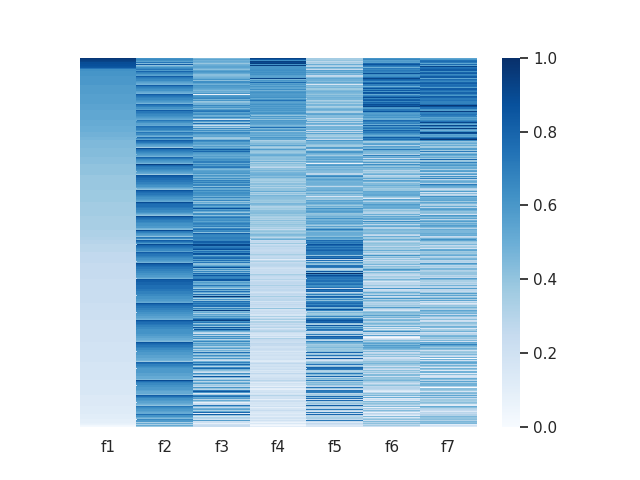

In [5]:
import seaborn as sns

# prefix = "data/c2dtlz2/c2dtlz2-5d-norm"
# xtickl = ["f1", "f2", "f3", "f4", "f5"]

# prefix = "data/iris/iris-4d-norm"
# xtickl = ["f1", "f2", "f3", "f4"]

# prefix = "data/mammogram/mammogram-5d-norm"
# xtickl = ["f1", "f2", "f3", "f4", "f5"]

prefix = "data/wil/wil-7d-norm"
xtickl = ["f1", "f2", "f3", "f4", "f5", "f6", "f7"]

sns.set()
points = utils.load(prefix + ".out")
points.sort(reverse = True)
data = np.array(points)
plt.figure()
ax = sns.heatmap(data, yticklabels = False, xticklabels = xtickl, cmap = 'Blues')
outfile_name = prefix + "-heatmap.pdf"
plt.savefig(outfile_name, transparent = False, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [13]:
s = [5, 1, 2, 3]
sorted(s)
print(s)

[5, 1, 2, 3]
